We deployed [the new M-Lab platform to 1/3rd of the M-Lab fleet](https://www.measurementlab.net/blog/global-pilot-entry/), and now we
need to assess whether or not the new platform is a performance regression, relative to the
old platform.  As long as we can be sure the performance of the new platform
does not constitute a regression, then we can roll out the new platform to
the rest of the M-Lab fleet around the world.

More concretely, for every site, we would like to be certain, at the 95% level
or above, that the performance data gathered on the new platform is not worse
(lower bandwidth) than the old platform at that same site.

We are in a situation that is an almost textbook case for statistical analaysis:
1. We have a lot of data
2. We have a question of interest (is the new platform worse than the old platform?)
3. We have a default action (roll out the new platform)

In developing an analysis, we want to be congnizant of a few important facts:
1. Internet performance is differently variable in different regions of the
   world.
2. Not all machines at a site are used equally. In particular, we know of some
   NDT clients which will ONLY run a test to `ndt.iupui.mlab1.lax03` and would
   never run a test to `ndt.iupui.mlab2.lax03` or `ndt.iupui.mlab3.lax03`.
3. The kubernetes platform is not rolled out to any `mlab1` machines.

Our needs and our constraints lead to the following per-site analysis method to
decide whether the new platform is not a regression at a given site:

Let us assume that for this site, the `mlab2` machine uses PlanetLab, vservers,
and web100 (a PL machine) and the `mlab3` machine uses Kubernetes, Docker, and tcp-info (a k8s machine).
1. Calculate the mean (both arithmetic mean and log mean) download and upload experienced by
   all NDT clients that connected to `mlab2` or `mlab3` during the month of
   September.  If the means for the new platform are both not worse
   than the means for the old platform, then we are done.  The
   performance of the new platform at that site does not constitute a
   regression.
2. If a mean has regressed at any site, then we calculate a "noise floor" for the site by doing the same
   analysis for January, February, ..., June of 2019.  During those months, all
   the `mlab3` machines were controlled by the old platform and as such, our
   monthly variation between sample means establishes a "noise floor".  We then
   compare the new difference (between the new and old) to the established noise
   floor (between the old and the old) to see whether it is within historical
   norms.  If we are 95% confident that the new performance differential is
   within historical norms, then we can conclude that the new performance at the
   site does not constitue a regression.
3. If the regression in performance is outside of historical norms, we conduct
   an investigation to discover why.

(Spoiler alert: every analysis we performed ended after step 1, because no means got worse)

Armed with this analysis method, we set about investigating M-Lab's Bigquery NDT data.  When a single client endpoint has tested against a server multiple times, we choose a random successful result to prevent any individual network endpoint from contributing too much to the final analysis. We then compare the mean and median of these "monthly bests" between the PL and k8s.

We first begin by constructing a basic query that filters out some bad-looking data and then creates two joinable tables containing per-site performance at the 0%, 10%, ... 90%, and 100% levels as well as per-site average performance.  Once we have both of these, we conduct two analyses: a visual one and a quantitative one.

In [1]:
from google.cloud import bigquery
client = bigquery.Client(project='measurement-lab')
query = '''with 
-- First, bring the old data and the new data into a common schema
-- Also throw out null data
-- First the data from the old platform
web100_performance_multiples AS (
  SELECT test_id,
    'web100' AS type,
    partition_date AS date,
    regexp_extract(
        connection_spec.server_hostname, 
        r"(mlab[0-9]\.[^.]*)\.measurement-lab.org") 
      AS host, 
    web100_log_entry.connection_spec.remote_ip AS client,
    8 * (web100_log_entry.snap.HCThruOctetsAcked
        / (web100_log_entry.snap.SndLimTimeRwin +
            web100_log_entry.snap.SndLimTimeCwnd +
            web100_log_entry.snap.SndLimTimeSnd)) 
      AS bandwidth_down,
    (web100_log_entry.snap.SndLimTimeRwin +
        web100_log_entry.snap.SndLimTimeCwnd +
        web100_log_entry.snap.SndLimTimeSnd) / 1000000.0
      AS duration
  FROM `measurement-lab.ndt.web100`
  WHERE web100_log_entry.connection_spec.local_ip IS NOT NULL
  AND web100_log_entry.connection_spec.remote_ip IS NOT NULL
  -- Download direction
  AND connection_spec.data_direction IS NOT NULL
  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked IS NOT NULL
  AND web100_log_entry.snap.HCThruOctetsAcked > 0
  -- Sum of SndLimTime* have real values.
  AND web100_log_entry.snap.SndLimTimeRwin IS NOT NULL
  AND web100_log_entry.snap.SndLimTimeCwnd IS NOT NULL
  AND web100_log_entry.snap.SndLimTimeSnd IS NOT NULL
),
-- Next the data from the new platform, making sure to use socket-level 
-- statistics instead of NDT's application-level statistics.
tcpinfo_performance_multiples AS (
  SELECT test_id,
    'tcpinfo' AS type,
    partition_date AS date,
    REPLACE(
        REGEXP_EXTRACT(
            ndt5.ParseInfo.TaskFileName,
            "-(mlab[1-4]-[a-z]{3}[0-9]{2})-"),
        "-",
        ".")
      AS host,
    result.ClientIP AS client,
    (FinalSnapshot.TCPInfo.BytesAcked*8/1000000)
        /(TIMESTAMP_DIFF(result.S2C.EndTime,
                         result.S2C.StartTime, 
                         MILLISECOND)/1000) 
      AS bandwidth_down,
    TIMESTAMP_DIFF(result.S2C.EndTime,
                   result.S2C.StartTime, 
                   MILLISECOND)/1000
      AS duration
  FROM `measurement-lab.ndt.ndt5` AS ndt5 
    INNER JOIN `mlab-oti.base_tables.tcpinfo` 
    ON (result.S2C.UUID = UUID)
  WHERE result.S2C IS NOT NULL
  AND result.S2C.ClientIP IS NOT NULL
  AND result.S2C.MeanThroughputMbps > 0
),
-- Now union the tables
performance_multiples_unfiltered AS (
  SELECT * FROM web100_performance_multiples 
  UNION ALL 
  SELECT * FROM tcpinfo_performance_multiples
),
-- Now that the data has a unified schema, filter it:
--  1) only the month of September 2019
--  2) A 10 second download should take between 9 and 20 seconds, even
--     accounting for client/server clock skew
--  3) Only those streams that averaged greater than 10Kbps, as below
--     that is poorly measured by many popular clients
--  4) Eliminate the results generated by M-Lab's OA&M infrastructure
--  5) No mlab1 machines, because their client pool is known to be
--     different
--  6) No yul02 machines, because mlab3.yul02 was in maintenance mode
--     for the month of September.
performance_multiples AS (
  SELECT type, regexp_extract(host, r"mlab[0-9]\.([^.]*)") AS site,
    client, test_id, bandwidth_down
  FROM performance_multiples_unfiltered
  WHERE 
     -- The month of September 2019
    date BETWEEN DATE("2019-09-01") AND DATE("2019-10-01")
     -- A 10 second download should take between 9 and 20 seconds
    AND duration BETWEEN 9 and 20
     -- Over 10kbps
    AND bandwidth_down > .01
    -- These IPs are used by M-Lab's OA&M infrastructure
    AND client NOT IN ("45.56.98.222", "35.192.37.249", "35.225.75.192", 
        "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", 
        "2605:a601:f1ff:fffe::99")
    -- No mlab1 machines
    AND host NOT LIKE '%mlab1%'
    -- No yul02 machines
    AND host NOT LIKE '%yul02%'
),
-- Next, for ip addresses with multiple tests, choose a random result.
performance AS (
  SELECT * EXCEPT(row_number) FROM (
    SELECT *, ROW_NUMBER()
    OVER (PARTITION BY CONCAT(site, client, type)
          ORDER BY FARM_FINGERPRINT(test_id)) AS row_number
    FROM performance_multiples)
  WHERE row_number = 1
)
-- Select the type of server, the site, and the descriptive statistics.
SELECT 
  type,
  site,
  AVG(bandwidth_down) AS mean_mbps,
  EXP(AVG(LN(bandwidth_down))) AS log_mean_mbps,
  approx_quantiles(bandwidth_down, 100) AS deciles
FROM performance
GROUP BY site, type
ORDER BY site, type
'''

In [2]:
def deciles_and_means_from_query(query):
    from collections import defaultdict as dd
    decile = dd(lambda: dd(lambda: [0 for _ in range(101)]))
    average = dd(lambda: dd(float))
    log_average = dd(lambda: dd(float))

    for row in client.query(query):
        decile[row['site']][row['type']] = row['deciles']
        average[row['site']][row['type']] = float(row['mean_mbps'])
        log_average[row['site']][row['type']] = float(row['log_mean_mbps'])

    for site in [x for x in decile]:
        if sum(decile[site]['web100']) == 0 or sum(decile[site]['tcpinfo']) == 0:
            del decile[site]
            if site in average:
                del average[site]
            if site in log_average:
                del log_average[site]
    return decile, average, log_average

In [3]:
decile, average, log_average = deciles_and_means_from_query(query)

In [4]:
%matplotlib inline

def plot_small_multiples(decile, average, log_average):
    import math
    import matplotlib.pyplot as plt
    columns = 5
    rows = math.ceil(len(decile) / float(columns))
    plt.rcParams['figure.figsize'] = [20,4*rows]
    for i, site in enumerate(sorted(decile)):
        current = plt.subplot(rows, columns, i+1)
        top = 3000
        plt.loglog(range(int(top+2)), range(int(top+2)))
        plt.text(top**.5, top**.5/10, site, ha='center', fontsize=48,
                 color='lightgray')
        plt.loglog(decile[site]['web100'], decile[site]['tcpinfo'],
                   label=site, linewidth=1, marker=".", markersize=10)
        plt.loglog([average[site]['web100']], [average[site]['tcpinfo']],
                   color='green', marker=".", markersize=30)
        plt.loglog([log_average[site]['web100']], [log_average[site]['tcpinfo']],
                   color='blue', marker=".", markersize=30)
        plt.xlim(left=.1, right=3000)
        plt.ylim(bottom=.1, top=3000)
        plt.setp(current.get_xticklabels(), visible=(i+columns >= len(decile)))
        plt.setp(current.get_yticklabels(), visible=((i%columns) == 0))

    plt.show()

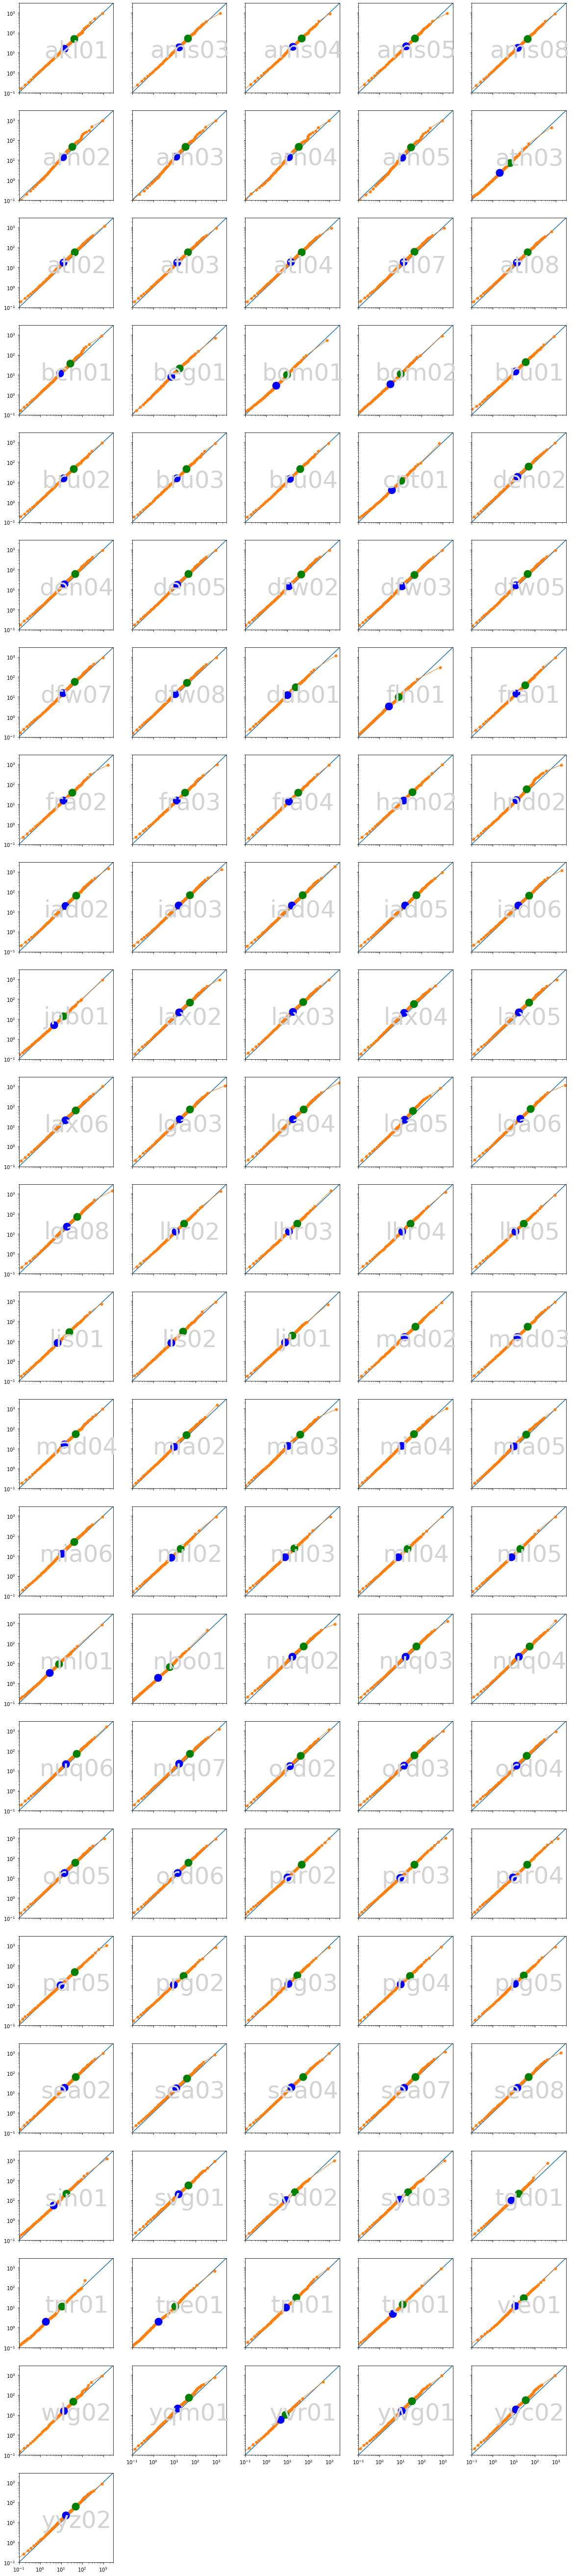

In [5]:
plot_small_multiples(decile, average, log_average)

The above graphs are QQ-plots showing comparative percentile performance for new and old software running at a given site.  Each orange dot is a percentile of performance (e.g. the 36th percentile), and the y value of the dot is that performance using the new software and the x value is the performance using the old software.  The orange and blue dots are the mean and log mean, respectively.  If the two distributions were exactly the same, then all dots would lie perfectly along the line `y=x`.

Looking at the resulting graphs, we can see that most of them track the line `y=x` pretty closely, implying a close match between the data derived from the old platform and the new platform.  The sites where they don't match but the orange dots are above the diagonal are precisely where the new platform is faster than the old platform.  The sites with an orange dot below the blue line are the set of sites where the last dot (representing the fastest 1%) lies to the right of the orange line.  This suggests that at high speeds there are some network contexts where Reno-based TCP stacks outperform CUBIC-based TCP stacks.  (As a sidenote - the last 1% is frequently a large outlier from the main body of results.  "Is bandwidth allocated more or less unequally than money in a region?" sounds like a really interesting research question that could be addressed by calculating a Gini coefficient for bandwidth and a Gini coefficient for wealth and then comparing them around the world...)  It is quite possible that we can alleviate even this last 1% mismatch in most cases by changing our switch configs - right now the switches are configured in the way which has been best measured to support Reno-based TCP.

That said, this entire analysis has been a visual one! We now embark on a quantitative analysis in an effort to put numbers on the quality of the match. We focus on one critical question: Is the expected performance on the new platform worse than the expected performance on the old platform?

If the average is higher on the new platform at a site, then there is no need to invoke the T-test machinery, because it is impossible to conclude, from a higher average, that the new system is worse.  The statistical machinery of the T-test is only required if we want to determine whether a difference is statistically 
significant. Because we are only interested in the one-side question of "Is the new platform worse?", we do not have to worry about statistical significance of claimed improvements.

Because our data spans multiple orders of magnitude, we calculate a histogram of per-site improvement using both the arithmetic mean as well as the logarithmic mean and see what sites have improved, and what sites have gotten worse, in an effort to answer the question: "Are the new sites worse than the old sites?"

In [6]:
%matplotlib inline
def print_histogram(average, name): # Can pass in average or log_average
    
    import io
    out = io.StringIO()
    sites = sorted((average[site]['tcpinfo'] / average[site]['web100'] * 100, site) for site in average)
    
    data = {}
    for i in range(0, 180, 10):
        data[i] = []
    for percent, site in sites:
        data[(percent//10) * 10].append(site)

    for x in data:
        data[x] = list(reversed(sorted(data[x])))
    
    maxlen = max(len(x) for x in data.values())
    minx = min([i for i in data if len(data[i]) > 0])
    if minx > 100:
        minx = 100
    maxx = max([i for i in data if len(data[i]) > 0])
    if maxx < 160:
        maxx = 160
    
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [(maxx-minx+4)*.2,.4*maxlen]
    
    plt.xlim(left=minx-20, right=maxx+20)
    plt.ylim(bottom=0, top=maxlen)
    plt.plot([0, 200], label=None)
    plt.yticks([])
    plt.xlabel(name, color='gray', fontsize=20)
    plt.xticks(
        range(minx-20, maxx+30, 10),
        [str(x)+'%' for x in range(minx-20, maxx+30, 10)],
        fontsize=20, fontweight='bold')

    for column in sorted(data):
        for row in range(len(data[column])):
            plt.text(column, row+.5, data[column][row], ha='center',
                     fontsize=20, color='black', fontfamily='monospace')
    f = plt.gcf()
    ax = f.axes[0]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

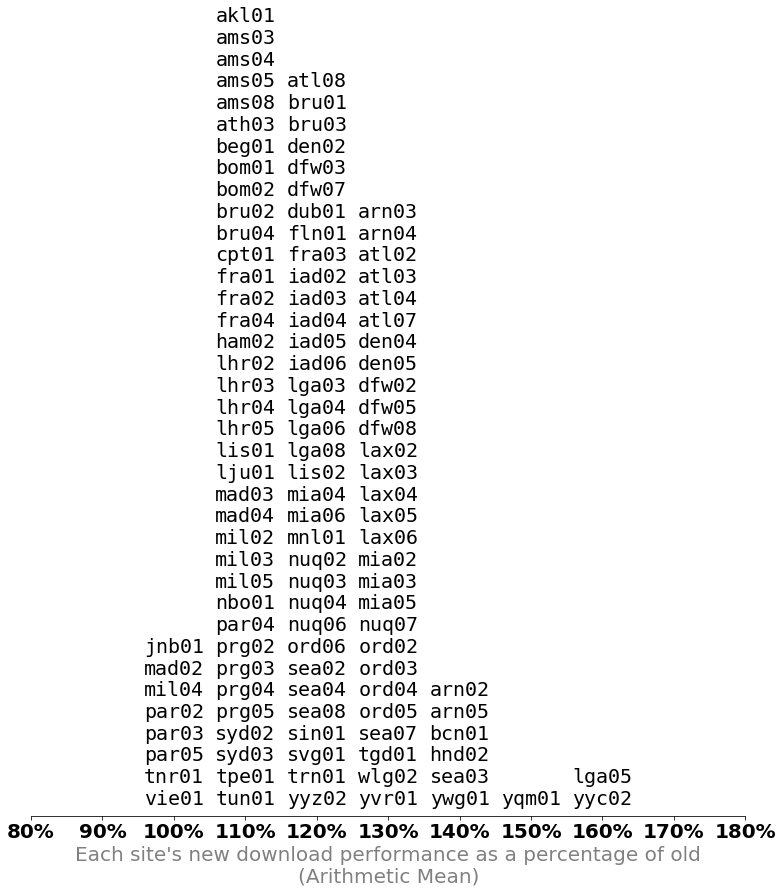

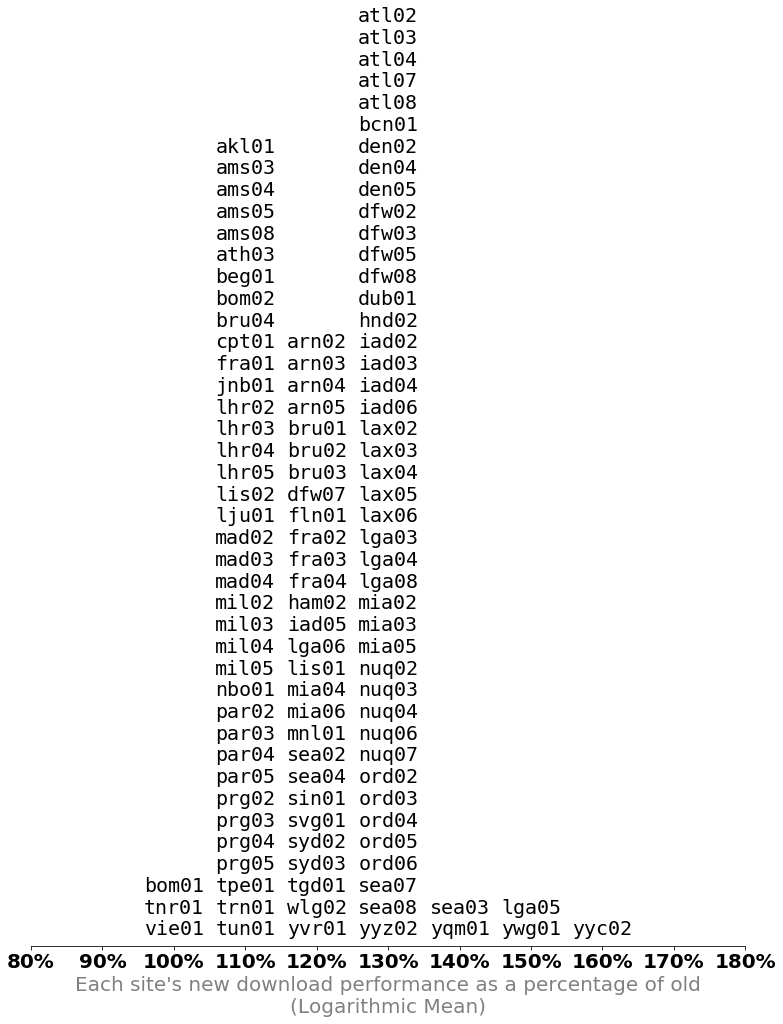

In [7]:
print_histogram(average, "Each site's new download performance as a percentage of old\n(Arithmetic Mean)")
print()
print_histogram(log_average, "Each site's new download performance as a percentage of old\n(Logarithmic Mean)")

From this histogram, we can see that literally every site is better under the new platform.  The expected performance under both definitions of the mean has improved between the old data and the new data.  This means that our new system is definitely not worse than the old platform for the download data, and there is no need to invoke statistical machinery to answer the question of "is this due to noise?", because we have no results to explain away as noise.  Everything has gotten better, and we would only need to perform an analysis if it had gotten worse.  

Next, for completeness, we redo the query and subsequent histogram for upload speeds.

In [8]:
up_query = '''with 
-- First, bring the old data and the new data into a common schema
-- Also throw out null data
-- First the data from the old platform
web100_performance_multiples AS (
  SELECT test_id,
    'web100' AS type,
    partition_date AS date,
    regexp_extract(
        connection_spec.server_hostname,
        r"(mlab[0-9]\.[^.]*)\.measurement-lab.org")
      AS host, 
    web100_log_entry.connection_spec.remote_ip AS client,
    8 * SAFE_DIVIDE(web100_log_entry.snap.HCThruOctetsReceived,
      IF(web100_log_entry.snap.Duration > 12000000,
         web100_log_entry.snap.Duration-2000000,
         web100_log_entry.snap.Duration))
    AS bandwidth_up,
      IF(web100_log_entry.snap.Duration > 12000000,
         web100_log_entry.snap.Duration-2000000,
         web100_log_entry.snap.Duration) / 1000000.0
    AS duration
  FROM `measurement-lab.ndt.web100`
  WHERE web100_log_entry.connection_spec.local_ip IS NOT NULL
  AND web100_log_entry.connection_spec.remote_ip IS NOT NULL
  -- Upload direction
  AND connection_spec.data_direction IS NOT NULL
  AND connection_spec.data_direction = 0
  AND web100_log_entry.snap.HCThruOctetsReceived IS NOT NULL
  AND web100_log_entry.snap.HCThruOctetsReceived > 0
  -- Duration has a value.
  AND web100_log_entry.snap.Duration IS NOT NULL
),
-- Next the data from the new platform
tcpinfo_performance_multiples AS (
  SELECT test_id,
    'tcpinfo' AS type,
    partition_date AS date,
    REPLACE(
        REGEXP_EXTRACT(
            ndt5.ParseInfo.TaskFileName,
            "-(mlab[1-4]-[a-z]{3}[0-9]{2})-"),
        "-",
        ".")
      AS host,
    result.C2S.ClientIP AS client,
    (FinalSnapshot.TCPInfo.BytesReceived * 8 / 1000000) / 
        (TIMESTAMP_DIFF(result.C2S.EndTime, result.C2S.StartTime, MILLISECOND)/1000) 
      AS bandwidth_up,
    TIMESTAMP_DIFF(
        result.C2S.EndTime, 
        result.C2S.StartTime, 
        MILLISECOND
    )/1000 AS duration
  FROM `measurement-lab.ndt.ndt5` AS ndt5 
    INNER JOIN `mlab-oti.base_tables.tcpinfo` 
    ON (result.C2S.UUID = UUID)
  WHERE result.C2S IS NOT NULL
  AND result.C2S.ClientIP IS NOT NULL
  AND result.C2S.MeanThroughputMbps > 0
),
-- Now union the tables
performance_multiples_unfiltered AS (
  SELECT * FROM web100_performance_multiples 
  UNION ALL 
  SELECT * FROM tcpinfo_performance_multiples
),
-- Now that the data has a unified schema, filter it:
--  1) only the month of September 2019
--  2) A 10 second upload should take between 9 and 20 seconds, 
--     even accounting for client/server clock skew
--  3) Only those streams that averaged greater than 10Kbps, 
--     because below that is poorly measured by many popular 
--     clients
--  4) Eliminate the results from M-Lab's OA&M infrastructure
--  5) No mlab1 machines, because their client pool is known 
--     to be different
--  6) No yul02 machines, because mlab3.yul02 was in maintenance
--     mode for the month of September.
performance_multiples AS (
  SELECT type, regexp_extract(host, r"mlab[0-9]\.([^.]*)") AS site, client, test_id, bandwidth_up
  FROM performance_multiples_unfiltered
  WHERE date BETWEEN DATE("2019-09-01") AND DATE("2019-10-01") -- The month of September 2019
    AND duration BETWEEN 9 and 20  -- A 10 second download should take between 9 and 20 seconds
    AND bandwidth_up > .01 -- Over 10kbps
    AND client NOT IN ("45.56.98.222", "35.192.37.249", "35.225.75.192", 
                       "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", 
                       "2605:a601:f1ff:fffe::99")  -- These IPs are used by M-Lab's OA&M infrastructure
    AND host NOT LIKE '%mlab1%' -- No mlab1 machines
    AND host NOT LIKE '%yul02%' -- No yul02 machines
),
-- Next, for ip addresses that performed multiple tests, we choose a random result.
performance AS (
  SELECT * EXCEPT(row_number) FROM (
    SELECT *, ROW_NUMBER() 
    OVER (PARTITION BY CONCAT(site, client, type)
          ORDER BY FARM_FINGERPRINT(test_id)) AS row_number
    FROM performance_multiples
  )
  WHERE row_number = 1
)
SELECT 
  type,
  site,
  AVG(bandwidth_up) AS mean_mbps,
  EXP(AVG(LN(bandwidth_up))) AS log_mean_mbps,
  approx_quantiles(bandwidth_up, 100) AS deciles
FROM performance
GROUP BY site, type
ORDER BY site, type
'''

decile_up, average_up, log_average_up = deciles_and_means_from_query(up_query)

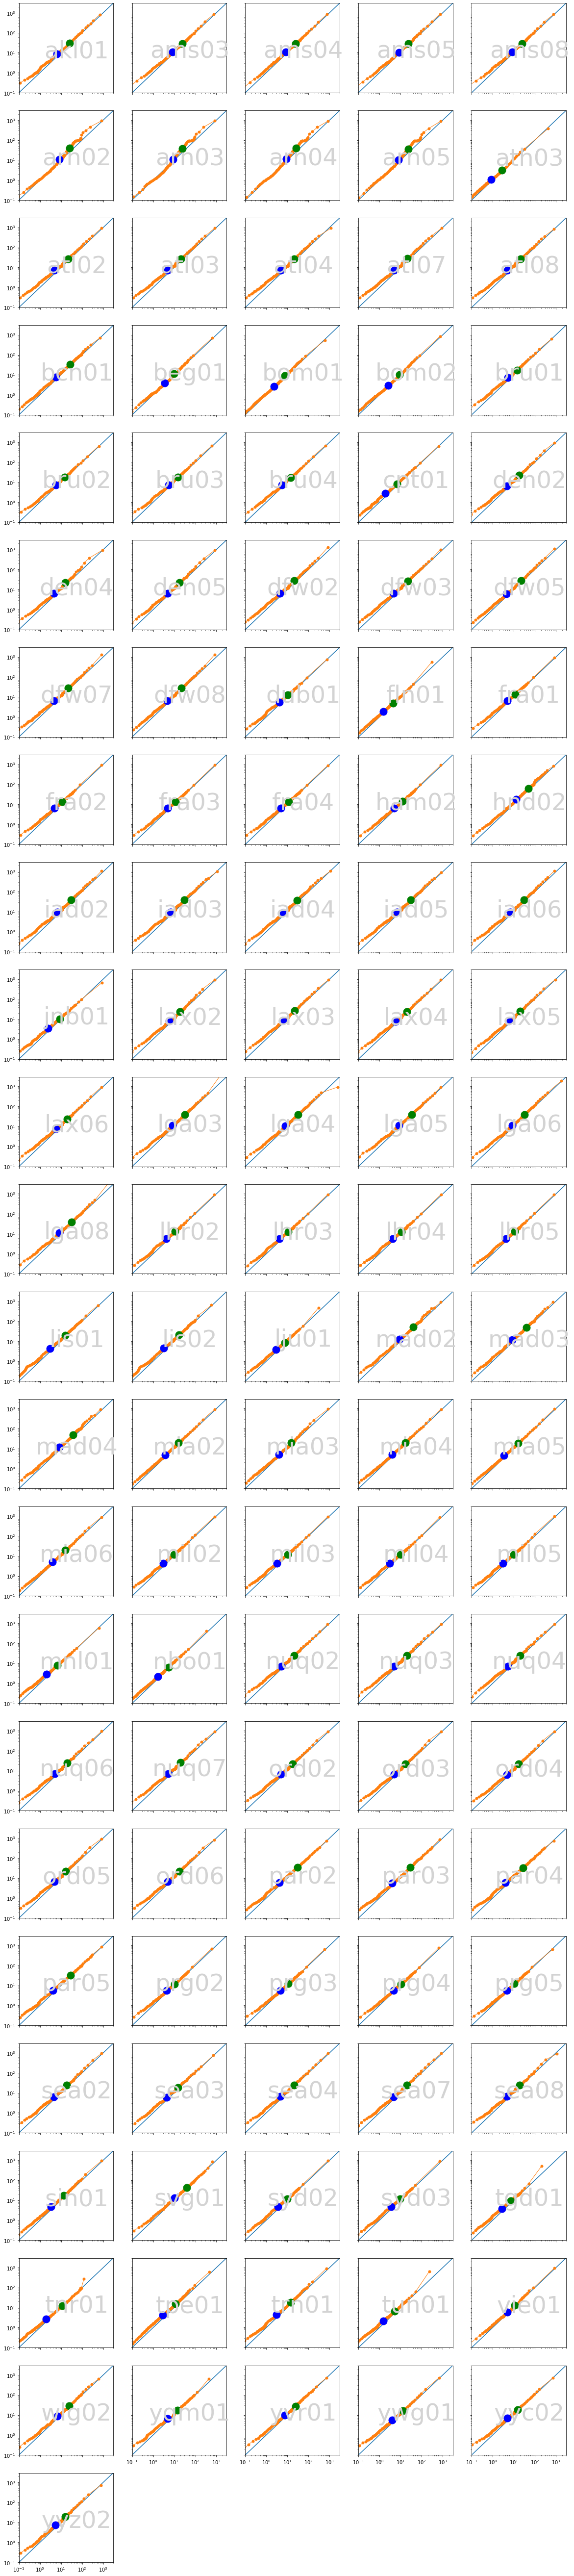

In [9]:
plot_small_multiples(decile_up, average_up, log_average_up)

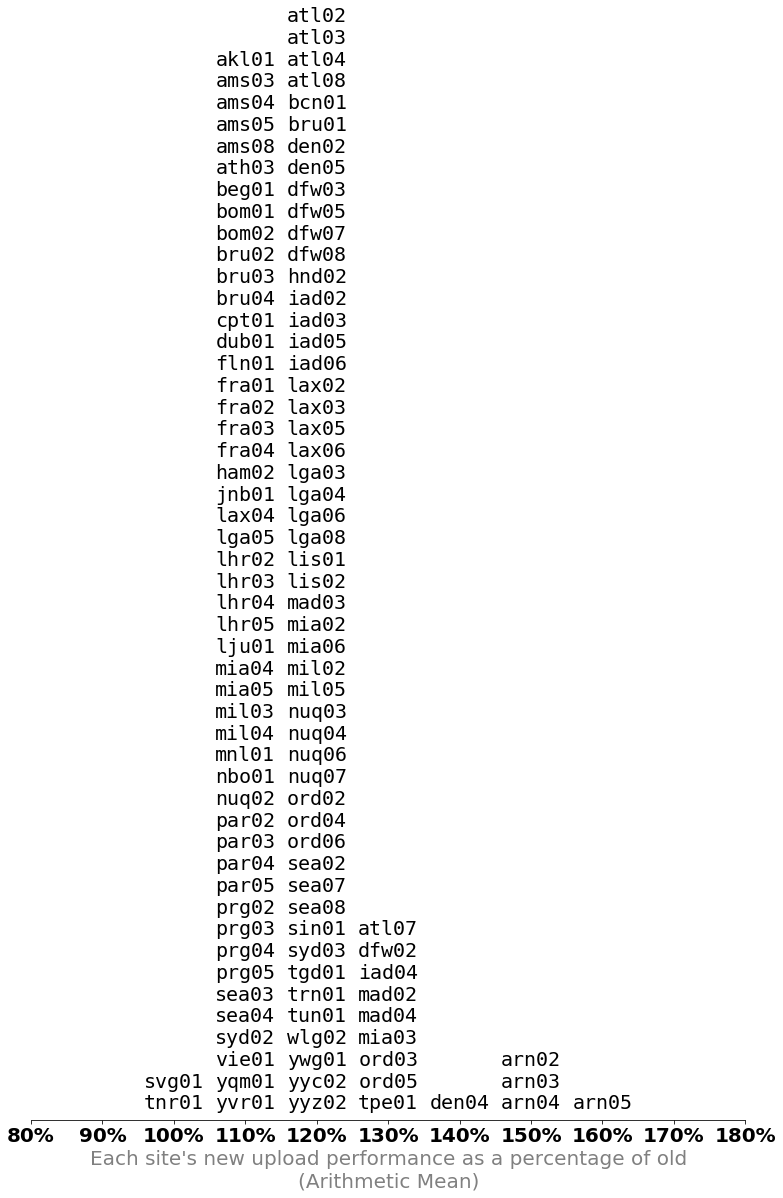

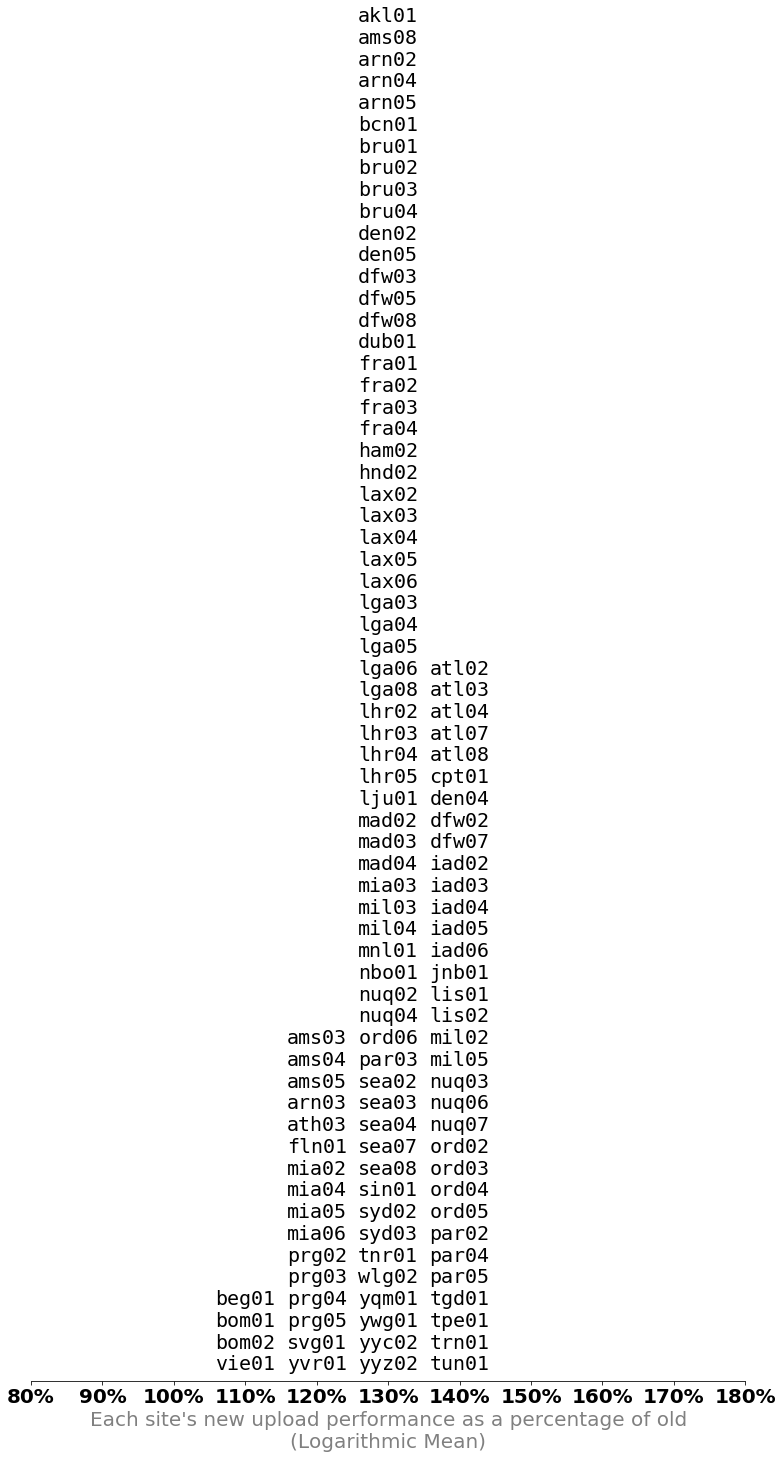

In [10]:
print_histogram(average_up, "Each site's new upload performance as a percentage of old\n(Arithmetic Mean)")
print()
print_histogram(log_average_up, "Each site's new upload performance as a percentage of old\n(Logarithmic Mean)")

Hooray! Nothing is worse with the uploads, either!  Because no mean at any site for uploads or downloads has gotten worse, it is safe to conclude that the new platform is not worse than the old platform, and that we should feel confident in rolling it out gradually to the rest of the fleet.  M-Lab 2.0 is good to go and is safe to be rolled out.

In the future, we will address the question of how to provide a continuous line through the old performance to the new performance, in an effort to preserve the longitudinal nature of the M-Lab dataset.  For today it is enough to determine that the new performance is not worse than the old, and that we can continue to safely roll out the system we have spent years building, confident that we are not making things worse.

# Appendix (reproducibility)

This analysis is intended to be reusable and verifiable. It was created by Peter Boothe <pboothe@google.com>, and this Jupyter notebook was run inside a docker container.  The docker container was created from a directory containing a single two-line file called `Dockerfile` with the following contents: 
```
from jupyter/datascience-notebook
run pip install --upgrade google-cloud-bigquery
```

The image was compiled locally and called `nbrunner`:
```
$ docker build . -t nbrunner
```

Finally the docker image was run from a directory containing the .ipynb file of this notebook, along with a few configuration flags to do some remapping of credentials and user ids across the docker abstraction boundary:
```
$ docker run -v `pwd`:`pwd` -v  ~/.config/gcloud/legacy_credentials/YOURGMAILADDRESS:/creds -w `pwd` -e GOOGLE_APPLICATION_CREDENTIALS=/creds/adc.json --net=host -it --user $UID --group-add users nbrunner
```

Anyone who is a member of <discuss@measurementlab.net> (which can be joined by the general public) can rerun this analysis notebook to reproduce these results, or to freely use these queries or subqueries for their own work.